In [ ]:
# Build a simple joke bot:
# The agent greets the user: “Hey, wanna hear a joke?”
# The user replies. The agent checks if they want a joke or not.
# If yes, the agent asks what kind of joke they want.
# The agent checks if the user’s preference is valid; if valid, it tells a joke, otherwise it prompts the user again.
# After telling a joke, the agent asks if the user wants another joke. This continues until the user says no, which ends the conversation.

## Libraries

In [ ]:
# Set OpenAI key in the environment
from google.colab import userdata
import os

api_key = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = api_key

In [ ]:
!pip install -q langchain-community langchain-openai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
from openai import OpenAI

from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import START, StateGraph, END

from IPython.display import Markdown, Image
from typing_extensions import TypedDict

import json
import ast

In [ ]:
# create openAI client
client = OpenAI()

In [ ]:
# a TypedDict class to store informations
class AgentState(TypedDict):
  topic: str
  topic_validity: str
  response: str
  cont: str
  recursion_limit: int

## Greetings

In [ ]:
def greet_user(state):
  system_msg = """
    Greet the user and ask if they want to hear a joke.
    Instruct them to answer with 'yes' or 'no'.
    Set a friendly tone of conversation.
  """

  completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {"role": "system",
        "content": system_msg
      }
      ],
    )

  greet = completion.choices[0].message.content
  print(greet)
  user_input = input()
  state['response'] = user_input

  return state

## Topic

In [ ]:
def get_topic(state):
  print('What type of joke are you in the mood for?')
  user_input = input()
  state['topic'] = user_input

  system_msg = """
    Validate the user's preference.
    Return as JSON:
    If valid, return {'valid': 'yes', 'response': <a joke related to the preference>}.
    If invalid, return {'valid': 'no', 'response': 'That topic isn't valid. Please choose another.'}.
  """

  completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {"role": "system",
        "content": system_msg
      },
      {
        "role": "user",
        "content": f"{state['topic']}"
      }
      ],
    response_format={ "type": "json_object" }
    )

   # get gpt answer
  try:
    bot = ast.literal_eval(completion.choices[0].message.content)
    state['topic_validity'] = bot['valid']
    print(bot['response'])
  except:
    response = json.loads(completion.choices[0].message.content)
    state['topic_validity'] = bot['valid']
    print(bot['response'])

  return state

## Router

In [ ]:
# function to repeatedly ask for the user's input
def continuation(state):
  print('Would you like to have another joke? [yes/no]')
  user_input = input()
  state['response'] = user_input

  return state

In [ ]:
# function to repeatedly ask for the user's input
def goodbye(state):
  print('Goodbye, See you next time!')
  return state

In [ ]:
def response_router(state):
  if state['response'].lower() == 'yes':
    return 'Continue'
  elif state['response'].lower() == 'no':
    return 'End'

In [ ]:
def topic_router(state):
  if state['topic_validity'].lower() == 'yes':
    return 'Valid'
  elif state['topic_validity'].lower() == 'no':
    return 'Invalid'

## Workflow

In [ ]:
# Initialize a StateGraph for workflow management, using AgentState as the state type
workflow = StateGraph(AgentState)

# Define nodes and their associated functions
workflow.add_node("Greet User", greet_user)
workflow.add_node("Get & Check Topic", get_topic)
workflow.add_node("Continue?", continuation)
workflow.add_node("Say Bye", goodbye)

# Set entry point for the workflow
workflow.set_entry_point("Greet User")

# Define conditional edges based on topic_router function outcomes
workflow.add_conditional_edges(
    "Greet User",
     response_router,
    {
        "Continue": "Get & Check Topic",
        "End":  "Say Bye"
    },
)

# Define conditional edges based on topic_router function outcomes
workflow.add_conditional_edges(
    "Get & Check Topic",
     topic_router,
    {
        "Valid": "Continue?",
        "Invalid":  "Get & Check Topic"
    },
)

# Define conditional edges based on topic_router function outcomes
workflow.add_conditional_edges(
    "Continue?",
     response_router,
    {
        "Continue": "Get & Check Topic",
        "End":  "Say Bye"
    },
)

workflow.add_edge("Say Bye", END)

# Compile the workflow into an application
app = workflow.compile()


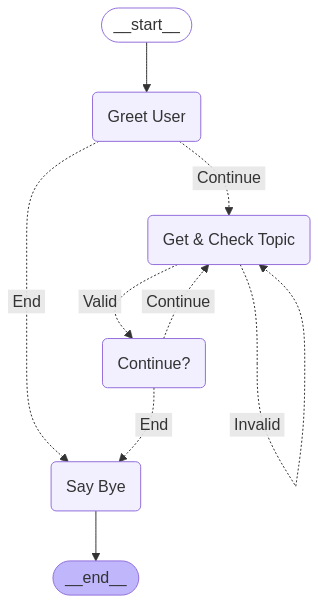

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
result = app.invoke({"recursion_limit": 50})

Hello there! 😊 Would you like to hear a joke today? Please answer with 'yes' or 'no'. I promise it'll be fun!
yes
What type of joke are you in the mood for?
murders
That topic isn't valid. Please choose another.
What type of joke are you in the mood for?
cats
Why was the cat sitting on the computer? It wanted to keep an eye on the mouse!
Would you like to have another joke? [yes/no]
yes
What type of joke are you in the mood for?
existensial crisis
Why don't existential crises make good stand-up comics? Because they're always questioning their purpose on the stage!
Would you like to have another joke? [yes/no]
no
Goodbye, See you next time!
